In [1]:
#Librerias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import plotly.express as px
import streamlit as st

In [2]:
df=pd.read_csv('USAHousingDataset.csv')
df['date'] = pd.to_datetime(df['date'])
#Calcular el precio por sqft
df['price_per_sqft'] = df['price'] / df['sqft_lot']

In [16]:
precio_ciudad = df.groupby('city')['price_per_sqft'].mean().reset_index()

# Inicializar geolocator
geolocator = Nominatim(user_agent="wa_price_map")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# Se agrega el estado de Washington en USA a cada ciudad para facilitar el geocode
def safe_geocode(city):
    try:
        return geocode(f"{city}, Washington, USA")
    except:
        return None

#Encontrar las coordenadas geográficas de cada ciudad
precio_ciudad['location'] = precio_ciudad['city'].apply(safe_geocode)
precio_ciudad['lat'] = precio_ciudad['location'].apply(lambda loc: loc.latitude if loc else None)
precio_ciudad['lon'] = precio_ciudad['location'].apply(lambda loc: loc.longitude if loc else None)

In [18]:
# Save ALREADY-PROCESSED artifact
precio_ciudad[['city', 'price_per_sqft', 'lat', 'lon']] \
    .to_parquet("precio_ciudad_map.parquet", index=False)

In [3]:
# Select only the columns needed for dashboard graphs
df_graphs = df[[
    "price", "yr_built", "view", "sqft_above",
    "sqft_living", "bathrooms", "bedrooms"
]]

# Save to parquet for fast loading
df_graphs.to_parquet("data_graphs.parquet", index=False)

In [40]:
# Gráfica geográfica usando plotly express scatter_map
fig = px.scatter_mapbox(
    pd.read_parquet("precio_ciudad_map.parquet"),
    lat='lat',
    lon='lon',
    size='price_per_sqft',
    color='price_per_sqft',
    hover_name='city',
    color_continuous_scale='Viridis',
    mapbox_style='carto-positron',
    zoom=7,
    title='Precio promedio por sqft por ciudad',
    width=700,
    height=700,
)

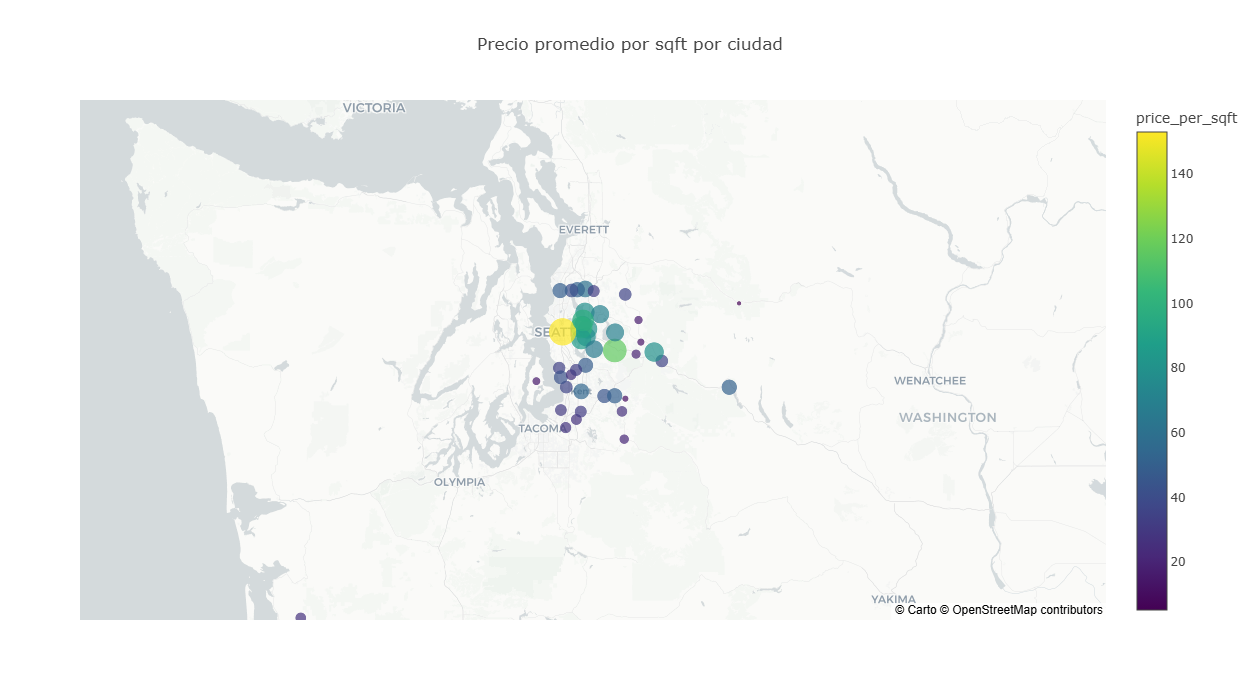

In [42]:
fig.show()